# **Numerical checks for the WongSolver**
In this notebook, we are going to perform various checks on our numerical routine for solving Wong's equations with Glasma background fields. 

## Comparison with `kappa.py` and `qhat.py` modules
In limiting cases, the momentum broadening of a parton may be extracted solely from Glasma fields. These cases are: an inifinitelly massive heavy quark, solved in `kappa.py` and an infinitely energetic jet moving along a certain direction, implemented in `qhat.py`. By choosing $m\rightarrow\infty$ in `wong.py`, we should the same momentum broadenings as from `kappa.py`, whereas initializing a parton with $p^x\rightarrow\infty$ should yield the same results as `qhat.py`. These comparisons represent solid numerical checks for the `wong.py` module.


### Default simulation parameters for the Glasma and the Wong solvers

Simulation parameters chosen for a Glasma characterized by a saturation momentum $Q_s=2\,\mathrm{GeV}$.

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 1024    
tau_sim = 10.0     
DTS = 2     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# Wong solver 
tau_form = 0
ntp = 10**5  
nevents = 3    
representation = 'fundamental'      
boundary = 'periodic'       

### Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CASIMIRS = True
from curraun.wong import init_mom_toy, init_pos, init_charge

Using CUDA
Using SU(3)
Using double precision
Using double precision


# Comparison with `qhat.py` for $p_x\rightarrow\infty$

In [3]:
# qhat module for jets
import curraun.qhat as qhat

mass = 1
px = 10**8 

### Simulation routine for evolving the Glasma & solving Wong's equations
Computes momentum broadenings from `wong.py` and `qhat.py`.

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('px', px / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))

    # Initialize the qhat.py module
    qhat_tforce = qhat.TransportedForce(s)
    mom_broad_qhat, tau_qhat =  [], []

    if use_cuda:
        qhat_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                # Compute momentum broadening from the qhat.py module
                if t % DTS == 0:
                    if use_cuda:
                        qhat_tforce.copy_mean_to_host()

                    mom_broad_qhat.append(qhat_tforce.p_perp_mean * E0 ** 2)
                    tau_qhat.append(t*a/DTS)
                    
                    if use_cuda:
                        qhat_tforce.copy_mean_to_device()
                qhat_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["mom_broad_qhat"], output["tau_qhat"] = mom_broad_qhat, tau_qhat

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

### Running the Wong solver over multiple Glasma events

In [5]:
mom_broads_wong, mom_broads_qhat = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    mom_broads_qhat.append(np.array(output["mom_broad_qhat"]))

mom_broad_wong, mom_broad_qhat = np.mean(mom_broads_wong, axis=0), np.mean(mom_broads_qhat, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)
tau_qhat = np.array(output["tau_qhat"])

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["mom_broad_qhat"], output["tau_qhat"] = mom_broad_qhat, tau_qhat
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_vs_qhat.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 3: 100%|██████████| 2048/2048 [52:31<00:00,  1.54s/it]


### Read data from files using Julia

In [3]:
using Pickle

output_jets = Pickle.npyload("wong_vs_qhat.pickle")
mom_broad_wong_jets, tau_wong_jets = output_jets["mom_broad_wong"], output_jets["tau_wong"]
mom_broad_qhat, tau_qhat = output_jets["mom_broad_qhat"], output_jets["tau_qhat"]

output_hqs = Pickle.npyload("wong_vs_kappa.pickle")
mom_broad_wong_hqs, tau_wong_hqs = output_hqs["mom_broad_wong"], output_hqs["tau_wong"]
mom_broad_kappa, tau_kappa = output_hqs["mom_broad_kappa"], output_hqs["tau_kappa"]

Qs, hbarc = output_jets["Qs"], output_jets["hbarc"]

(2, 0.197326)

### Plot transverse and longitudinal momentum broadenings, using Makie from Julia

In [ ]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 11, categorical = true)
colors = [segmented_cmap[11], segmented_cmap[4], segmented_cmap[1]]

## Read data from files

In [8]:
import pickle

output = pickle.load(open('wong_vs_qhat.pickle', 'rb'))
mom_broad_wong, tau_wong = output["mom_broad_wong"], output["tau_wong"]
mom_broad_qhat, tau_qhat = output["mom_broad_qhat"], output["tau_qhat"]
Qs, hbarc = output["Qs"], output["hbarc"]

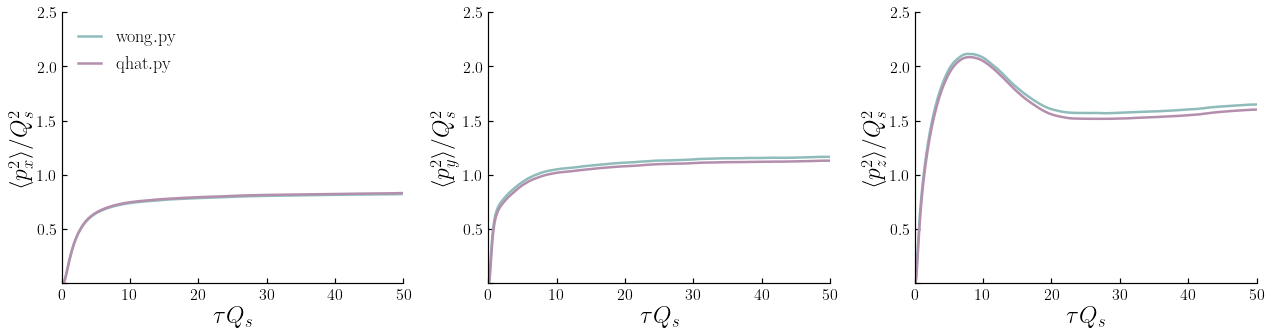

In [9]:
import matplotlib.pyplot as plt
import numpy as np 

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (18,5)
plt.rcParams["figure.subplot.wspace"] = 0.2

fig, ax = plt.subplots(1, 3)

# labels = [r'$\langle p_x^2\rangle\,\mathrm{[GeV^2]}$', r'$\langle p_y^2\rangle\,\mathrm{[GeV^2]}$', r'$\langle p_z^2\rangle\,\mathrm{[GeV^2]}$']
# for i in range(3):
#     ax[i].plot(tau_wong, mom_broad_wong[:, i],  label=r'$\mathrm{wong.py}$')
#     ax[i].plot(tau_qhat, mom_broad_qhat[:, i], label=r'$\mathrm{qhat.py}$')
#     ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')
#     ax[i].set_ylabel(labels[i])

# dimensionless quantities
labels = [r'$\langle p_x^2\rangle/Q_s^2$', r'$\langle p_y^2\rangle/Q_s^2$', r'$\langle p_z^2\rangle/Q_s^2$']
for i in range(3):
    ax[i].plot(tau_wong*Qs/hbarc, mom_broad_wong[:, i]/Qs**2,  label=r'$\mathrm{wong.py}$', linewidth=2.5)
    ax[i].plot(tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs**2, label=r'$\mathrm{qhat.py}$', linewidth=2.5)
    ax[i].set_xlabel(r'$\tau Q_s$')
    ax[i].set_ylabel(labels[i])
    ax[i].set_xlim(0, 50)
    ax[i].set_ylim(0, 2.5)
    ax[i].yaxis.get_major_ticks()[0].label1.set_visible(False)

ax[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('wong_vs_qhat.png', dpi=300, transparent=False, facecolor='white')

# Comparison with `kappa.py` for $m\rightarrow\infty$

In [11]:
# kappa module for heavy quarks
import curraun.kappa as kappa

mass = 10**5
pT = 0 

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes momentum broadenings from `wong.py` and `kappa.py`.

In [12]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))

    # Initialize the Kappa module
    kappa_tforce = kappa.TransportedForce(s)
    mom_broad_kappa, tau_kappa =  [], []

    if use_cuda:
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                # Compute momentum broadening from Kappa module
                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    mom_broad_kappa.append(kappa_tforce.p_perp_mean * E0 ** 2)
                    tau_kappa.append(t*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()
                kappa_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

## Running the Wong solver over multiple Glasma events

In [5]:
mom_broads_wong, mom_broads_kappa = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    mom_broads_kappa.append(np.array(output["mom_broad_kappa"]))

mom_broad_wong, mom_broad_kappa = np.mean(mom_broads_wong, axis=0), np.mean(mom_broads_kappa, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)
tau_kappa = np.array(output["tau_kappa"])

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_vs_kappa.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 1: 100%|██████████| 2048/2048 [48:34<00:00,  1.42s/it]


## Read data from files

In [6]:
import pickle

output_jets = pickle.load(open('wong_vs_qhat.pickle', 'rb'))
mom_broad_wong_jets, tau_wong_jets = output_jets["mom_broad_wong"], output_jets["tau_wong"]
mom_broad_qhat, tau_qhat = output_jets["mom_broad_qhat"], output_jets["tau_qhat"]
Qs, hbarc = output_jets["Qs"], output_jets["hbarc"]

output_hqs = pickle.load(open('wong_vs_kappa.pickle', 'rb'))
mom_broad_wong_hqs, tau_wong_hqs = output_hqs["mom_broad_wong"], output_hqs["tau_wong"]
mom_broad_kappa, tau_kappa = output_hqs["mom_broad_kappa"], output_hqs["tau_kappa"]

In [8]:
factor = 4
interp_tau_kappa = np.linspace(tau_kappa[0],tau_kappa[len(tau_kappa)-1],int(len(tau_kappa)/4))
interp_mom_broad_kappa = np.interp(interp_tau_kappa, tau_kappa, mom_broad_kappa[:, 2])
print(len(interp_mom_broad_kappa))

256


## Plot transverse and longitudinal momentum broadenings
Comparison between `kappa.py` and `wong.py` with $m\rightarrow\infty$ for infinitely massive heavy quarks and between `qhat.py` and `wong.py` with $p^x\rightarrow\infty$ for highly energetic jet.

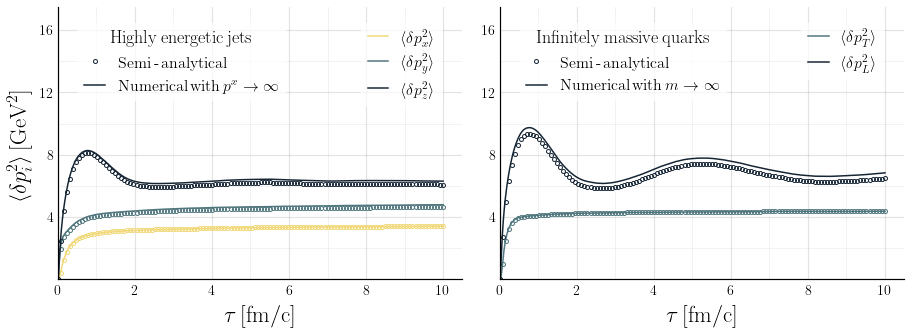

In [23]:
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import MultipleLocator
import matplotlib

matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

plt.style.use('custom_style.mpltstyle')
plt.rcParams["figure.figsize"] = (13,5)

fig, ax = plt.subplots(1, 2)

colors = ['#F1D878', '#51777E', '#162534']
ax[0].set_ylabel(r'$\langle \delta p^2_i\rangle\,\mathrm{[GeV^2]}$')

# interpolate kappa and qhat results 
factor = 8
interp_tau_kappa = np.linspace(tau_kappa[0],tau_kappa[len(tau_kappa)-1],int(len(tau_kappa)/factor))
interp_tau_qhat = np.linspace(tau_qhat[0],tau_qhat[len(tau_qhat)-1],int(len(tau_qhat)/factor))

# jets
for i in range(3):
    ax[0].plot(tau_wong_jets, mom_broad_wong_jets[:, i],  linewidth=1.5, color=colors[i])
    # ax[0].plot(tau_qhat, mom_broad_qhat[:, i], linewidth=1.5, color=colors[i], linestyle='--')
    interp_mom_broad_qhat = np.interp(interp_tau_qhat, tau_qhat, mom_broad_qhat[:, i])
    ax[0].plot(interp_tau_qhat, interp_mom_broad_qhat, linewidth=0, color=colors[i], markersize=4, marker='o', mfc='none')


lines_jets = ax[0].get_lines()
labels_jets = [r'$\langle \delta p^2_x\rangle$', r'$\langle \delta p^2_y\rangle$', r'$\langle \delta p^2_z\rangle$']
legend_jets = ax[0].legend([lines_jets[i] for i in [0, 2, 4]], labels_jets, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97))
labels_comp_jets = [r'$\mathrm{Semi}\,\text{-}\,\mathrm{analytical}$', r'$\mathrm{Numerical\,with\,}p^x\rightarrow\infty$']
legend_comp_jets = ax[0].legend([lines_jets[i] for i in [5, 4]], labels_comp_jets, loc = 'upper left', ncol=1, bbox_to_anchor=(0.03,0.97), title=r'$\mathrm{Highly\,energetic\,jets}$')
ax[0].add_artist(legend_jets)

# heavy quarks
# transverse
ax[1].plot(tau_wong_hqs, mom_broad_wong_hqs[:, 0]+mom_broad_wong_hqs[:, 1], linewidth=1.5, color=colors[1])
# ax[1].plot(tau_kappa, mom_broad_kappa[:, 0]+mom_broad_kappa[:, 1],  linewidth=1.5, color=colors[1], linestyle='--')  
interp_mom_broad_kappa_T = np.interp(interp_tau_kappa, tau_kappa, mom_broad_kappa[:, 0]+mom_broad_kappa[:, 1])
ax[1].plot(interp_tau_kappa, interp_mom_broad_kappa_T, linewidth=0, color=colors[1], markersize=4, marker='o', mfc='none')  

# longitudinal
ax[1].plot(tau_wong_hqs, mom_broad_wong_hqs[:, 2],  linewidth=1.5, color=colors[2])
# ax[1].plot(tau_kappa, mom_broad_kappa[:, 2], linewidth=1.5, color=colors[2], linestyle='--')  
interp_mom_broad_kappa_L = np.interp(interp_tau_kappa, tau_kappa, mom_broad_kappa[:, 2])
ax[1].plot(interp_tau_kappa, interp_mom_broad_kappa_L, linewidth=0, color=colors[2], markersize=4, marker='o', mfc='none') 



for i in range(2):
    ax[i].set_ylim(0, 17.5)
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')
    ax[i].set_xlim(0, 10.5)

    ax[i].yaxis.set_major_locator(MultipleLocator(4))
    yticks = [4, 8, 12, 16]
    ax[i].set_yticks(yticks)
    ylabels = [r'$4$', r'$8$', r'$12$', r'$16$']
    ax[i].set_yticklabels(ylabels) 

    ax[i].grid(visible=True, which='major', axis='both')

    ax[i].minorticks_on()
    ax[i].yaxis.set_minor_locator(MultipleLocator(2))
    ax[i].xaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(visible=True, which='minor', axis='both', alpha=0.1, linewidth=0.9)

lines_hqs = ax[1].get_lines()
labels_hqs = [r'$\langle \delta p^2_T\rangle$', r'$\langle \delta p^2_L\rangle$']
legend_hqs = ax[1].legend([lines_hqs[i] for i in [0, 2]], labels_hqs, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97))
labels_comp_hqs = [r'$\mathrm{Semi}\,\text{-}\,\mathrm{analytical}$', r'$\mathrm{Numerical\,with\,}m\rightarrow\infty$']
legend_comp_hqs = ax[1].legend([lines_hqs[i] for i in [3, 2]], labels_comp_hqs, loc = 'upper left', ncol=1, bbox_to_anchor=(0.03,0.97), title=r'$\mathrm{Infinitely\,massive\,quarks}$')
ax[1].add_artist(legend_hqs)

plt.tight_layout()

In [25]:
reduced_tau_kappa = tau_kappa[tau_kappa % 0.01 == 0]
print(len(tau_kappa))
factor = 4
interp_tau_kappa = np.linspace(tau_kappa[0],tau_kappa[len(tau_kappa)-1],int(len(tau_kappa)/4))
interp_mom_broad_kappa = np.interp(interp_tau_kappa, tau_kappa, mom_broad_kappa[:, 2])
print(len(interp_mom_broad_kappa))

1024
256


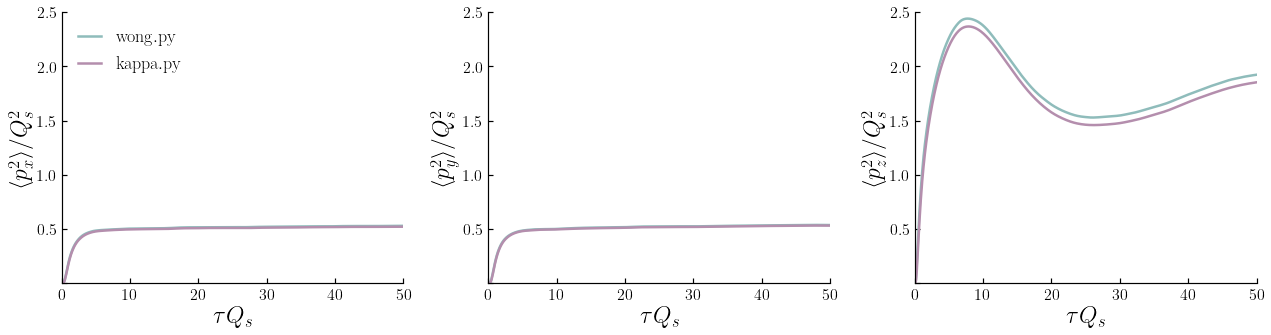

In [7]:
import matplotlib.pyplot as plt
import numpy as np 

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (18,5)
plt.rcParams["figure.subplot.wspace"] = 0.2

fig, ax = plt.subplots(1, 3)

# dimensionless quantities
labels = [r'$\langle p_x^2\rangle/Q_s^2$', r'$\langle p_y^2\rangle/Q_s^2$', r'$\langle p_z^2\rangle/Q_s^2$']
for i in range(3):
    ax[i].plot(tau_wong*Qs/hbarc, mom_broad_wong[:, i]/Qs**2,  label=r'$\mathrm{wong.py}$', linewidth=2.5)
    ax[i].plot(tau_kappa*Qs/hbarc, mom_broad_kappa[:, i]/Qs**2, label=r'$\mathrm{kappa.py}$', linewidth=2.5)
    ax[i].set_xlabel(r'$\tau Q_s$')
    ax[i].set_ylabel(labels[i])
    ax[i].set_xlim(0, 50)
    ax[i].set_ylim(0, 2.5)
    ax[i].yaxis.get_major_ticks()[0].label1.set_visible(False)

ax[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('wong_vs_kappa.png', dpi=300, transparent=False, facecolor='white')

## Read data from files

In [ ]:
import pickle

output = pickle.load(open('wong_vs_kappa.pickle', 'rb'))
mom_broad_wong, tau_wong = output["mom_broad_wong"], output["tau_wong"]
mom_broad_kappa, tau_kappa = output["mom_broad_kappa"], output["tau_kappa"]
Qs, hbarc = output["Qs"], output["hbarc"]

# Longitudinal momentum broadening and total energy

In [12]:
# Wong modules
from curraun import wong
wong.CASIMIRS = False
wong.BOUNDARY = boundary
# wong.LIMITING_CASE = True
from curraun.wong import init_mom_toy, init_pos, init_charge  

tau_sim = 10.0

In [13]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))
    energies = np.zeros((maxt-formt, ntp))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()
                wong_solver.compute_energy()
                energies[t-formt] = wong_solver.e * E0

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["energy"] = np.mean(energies,axis=1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

In [14]:
mom_broads_wong, energies = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    energies.append(np.array(output["energy"]))

mom_broad_wong, energy = np.mean(mom_broads_wong, axis=0), np.mean(energies, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["Qs"], output["hbarc"] = Qs, hbarc
output["energy"] = energy

filename = 'wong_energy.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 1: 100%|██████████| 4096/4096 [22:16<00:00,  3.06it/s]


In [15]:
import pickle

output = pickle.load(open('wong_energy.pickle', 'rb'))
mom_broad_wong, tau_wong = output["mom_broad_wong"], output["tau_wong"]
Qs, hbarc = output["Qs"], output["hbarc"]
energy = output["energy"]

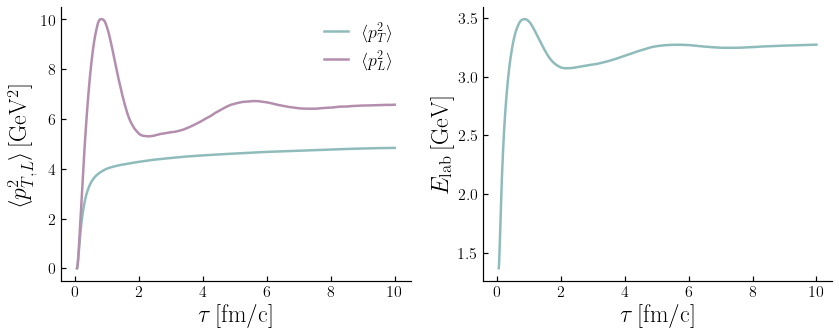

In [26]:
import matplotlib.pyplot as plt
import numpy as np 

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["figure.subplot.wspace"] = 0.2

fig, ax = plt.subplots(1, 2)

# dimensionless quantities
# labels = [r'$\langle p_x^2\rangle/Q_s^2$', r'$\langle p_y^2\rangle/Q_s^2$', r'$\langle p_z^2\rangle/Q_s^2$']
for i in range(2):
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')
    # ax[i].set_xlim(0, 50)

ax[0].set_ylabel(r'$\langle p^2_{T,L}\rangle\,\mathrm{[GeV^2]}$')
ax[0].plot(tau_wong, mom_broad_wong[:, 0]+mom_broad_wong[:, 1], linewidth=2.5, label=r'$\langle p_T^2\rangle$')
ax[0].plot(tau_wong, mom_broad_wong[:, 2], linewidth=2.5, label=r'$\langle p_L^2\rangle$')

ax[1].set_ylabel(r'$E_\mathrm{lab}\,\mathrm{[GeV]}$')
ax[1].plot(tau_wong, energy, linewidth=2.5)
    
    # ax[i].set_ylabel(labels[i])
    
    # ax[i].set_ylim(0, 2.5)
    # ax[i].yaxis.get_major_ticks()[0].label1.set_visible(False)

ax[0].legend(loc='upper right')

plt.tight_layout()
plt.savefig('wong_energy.png', dpi=300, transparent=False, facecolor='white')